# RSS18 Scenario 2

This is "Scenario 2" of the Mars exploration-inspired example that appeared in the following paper:

Petter Nilsson, Sofie Haesaert, Rohan Thakker, Kyohei Otsu, Cristian-Ioan Vasile, Ali-akbar Agha-Mohammadi, Aaron D. Ames and Richard M. Murray, **Toward Specification-Guided Active Mars Exploration for Cooperative Robot Teams**, in *Proceedings of Robotics: Science and Systems Conference*, 2018

**Note**: parts of the code have been updated and improved since the time of submission. Therefore, results identical to the ones that appear in the paper can not be expected due to differences in numerics and randomness. To reproduce exact results, see this [release](https://github.com/pettni/pdf-abstraction/tree/v0.0.2).

In [1]:
import polytope as pc
from collections import OrderedDict
import numpy as np

prob = {}
prob['rov_T'] = 15
prob['cop_T'] = 30
prob['rov_x0'] = np.array([0.5, -4.5])
prob['cop_x0'] = np.array([-0.5, -4.5, 2])
prob['cop_xT'] = np.array([4.5, -4.5, 2])
prob['cop_sight'] = 2
prob['weak_accu'] = 0.85
prob['prob_margin'] = 0.1

prob['formula'] = '( ( ! fail U sampleA ) & ( ! fail U sampleB ) ) | ( ! fail U ( sampleC ) )'

regs = OrderedDict()

regs['r1'] = (pc.box2poly(np.array([[2, 3], [0, 5]])), 0.5, 'red')
regs['r2'] = (pc.box2poly(np.array([[-3, -2], [1, 5]])), 1, 'red')
regs['r3'] = (pc.box2poly(np.array([[-5, -3], [0, 1]])), 0.5, 'red')
regs['a1'] = (pc.box2poly(np.array([[-1, 1], [4, 5]])), 0.5, 'green')
regs['b1'] = (pc.box2poly(np.array([[4, 5], [4, 5]])), 0.5, 'blue')
regs['c1'] = (pc.box2poly(np.array([[-5, -4], [4, 5]])), 0.5, 'blue')

prob['regs'] = regs
prob['env_Nlist'] = [1 if  reg[1] in [0,1] else 5 for reg in regs.values()]
prob['env_x0'] = [0 if  reg[1] in [0,1] else 2 for reg in regs.values()]

In [2]:
# plot workspace
from best.abstraction.gridding import Abstraction
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rss18_functions as rf

# rover model
rover_abstr = Abstraction([-5, -5], [5, 5], [10, 10], name_prefix='r')

fig = plt.figure(figsize=(5, 5))
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abstr.plot(ax)

for name, info in regs.items():
    rf.plot_region(ax, info[0], name, info[1], info[2])
    
ax.text(prob['rov_x0'][0]+0.1, prob['rov_x0'][1]+0.1, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle(  prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))
ax.text( prob['cop_x0'][0]+0.1, prob['cop_x0'] [1]+0.1, '$\\xi_c^0$')

fig.savefig('exp2-workspace.pdf')

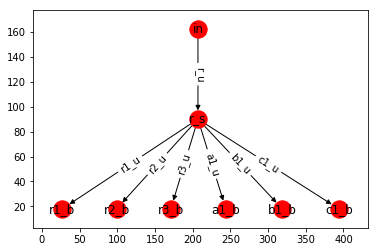

MDP network: (5,) inputs ('r_u',), (100, 5, 1, 5, 5, 5, 5) states ('r_s', 'r1_b', 'r2_b', 'r3_b', 'a1_b', 'b1_b', 'c1_b'), (100, 5, 1, 5, 5, 5, 5) outputs ('r_x', 'r1_b', 'r2_b', 'r3_b', 'a1_b', 'b1_b', 'c1_b')


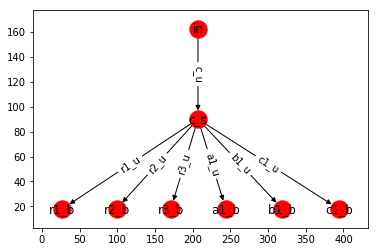

MDP network: (7,) inputs ('c_u',), (200, 5, 1, 5, 5, 5, 5) states ('c_s', 'r1_b', 'r2_b', 'r3_b', 'a1_b', 'b1_b', 'c1_b'), (200, 5, 1, 5, 5, 5, 5) outputs ('c_x', 'r1_b', 'r2_b', 'r3_b', 'a1_b', 'b1_b', 'c1_b')


In [3]:
# create systems
from best.models.pomdp import POMDPNetwork

# copter model
copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2], name_prefix='c')

# Environment belief model
env_list = [rf.environment_belief_model(info[1], [1-prob['weak_accu'], prob['weak_accu']], name) 
            for (name, info) in regs.items()]

# Construct rover-env network
rover_env_network = POMDPNetwork([rover_abstr.pomdp] + env_list)
for item in prob['regs'].items():
    rover_env_network.add_connection(['r_x'], '{}_u'.format(item[0]), rf.get_rover_env_conn(item))

# Construct copter-env network
copter_env_network = POMDPNetwork([copter_abstr.pomdp] + env_list)
for item in prob['regs'].items():
    copter_env_network.add_connection(['c_x'], '{}_u'.format(item[0]), rf.get_copter_env_conn(item, prob['cop_sight']))

rover_env_network.plot()
plt.show()
print (rover_env_network)

copter_env_network.plot()
plt.show()
print (copter_env_network)

In [4]:
# solve rover LTL problem
from best.solvers.valiter import solve_ltl_cosafe

predicates = rf.get_predicates(prob['regs'])
rover_ltlpol = solve_ltl_cosafe(rover_env_network, prob['formula'], predicates,
                                horizon=prob['rov_T'], verbose=True)

constructing augmented network...
finished constructing augmented network in 0.18s
iteration 0, time 0.01
iteration 1, time 1.84
iteration 2, time 3.14
iteration 3, time 4.43
iteration 4, time 5.77
iteration 5, time 7.14
iteration 6, time 8.44
iteration 7, time 9.73
iteration 8, time 11.04
iteration 9, time 12.34
iteration 10, time 13.63
iteration 11, time 14.93
iteration 12, time 16.24
iteration 13, time 17.54
iteration 14, time 18.83
finished after 20.15s and 15 iterations


In [5]:
from best.solvers.valiter import solve_reach_constrained

# set up target set
init_rov = rover_abstr.x_to_s(prob['rov_x0'])
init_dfsa = rover_ltlpol.dfsa_init
v_max = np.max(rover_ltlpol.val[0].flatten())
idx = np.logical_or(rover_ltlpol.val[0][init_rov, ..., init_dfsa] > v_max-prob['prob_margin'],
                    rover_ltlpol.val[0][init_rov, ..., init_dfsa] < prob['prob_margin'])
Vacc = np.zeros(copter_env_network.N)
Vacc[:, idx] = 1

# constraint set (landing)
Vcon = np.zeros(copter_env_network.N)
Vcon[copter_abstr.x_to_s(prob['cop_xT']), :] = 1
val_copt_list, pol_copt_list = solve_reach_constrained(copter_env_network, 
                                                       Vacc, [(Vcon, 0.95)], 
                                                       horizon=prob['cop_T'], verbose=True)

iteration 0, time 0.00
iteration 1, time 0.52
iteration 2, time 0.96
iteration 3, time 1.38
iteration 4, time 1.86
iteration 5, time 2.30
iteration 6, time 2.73
iteration 7, time 3.16
iteration 8, time 3.52
iteration 9, time 3.90
iteration 10, time 4.29
iteration 11, time 4.60
iteration 12, time 5.04
iteration 13, time 5.44
iteration 14, time 5.81
iteration 15, time 6.19
iteration 16, time 6.65
iteration 17, time 7.07
iteration 18, time 7.46
iteration 19, time 7.87
iteration 20, time 8.33
iteration 21, time 8.74
iteration 22, time 9.12
iteration 23, time 9.49
iteration 24, time 9.86
iteration 25, time 10.31
iteration 26, time 10.74
iteration 27, time 11.12
iteration 28, time 11.53
iteration 29, time 11.99
finished after 12.40s and 30 iterations


In [6]:
# save controllers
copter_policy = rf.CopterPolicy(pol_copt_list, val_copt_list, copter_abstr)
rover_policy = rf.RoverPolicy(rover_ltlpol, rover_abstr)

if False:
    import cPickle as pickle
    with open('policies.pickle', 'wb') as fp:
      pickle.dump((copter_policy, rover_policy, prob), fp)

success probability: 0.25


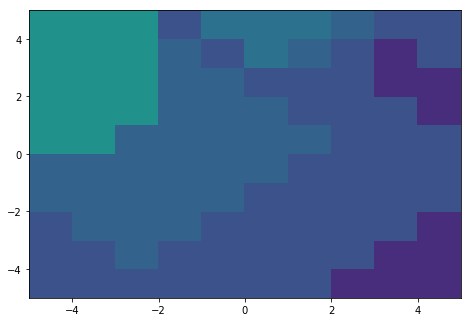

In [7]:
# plot rover value fcn
def my_value(x, mapstate):    
    s_abstr = rover_abstr.x_to_s(x)
    _, val = rover_ltlpol((s_abstr,) + tuple(mapstate))
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), prob['env_x0'])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print ('success probability: {}'.format(my_value(prob['rov_x0'], prob['env_x0'])))

success value: 0.6889062523841858


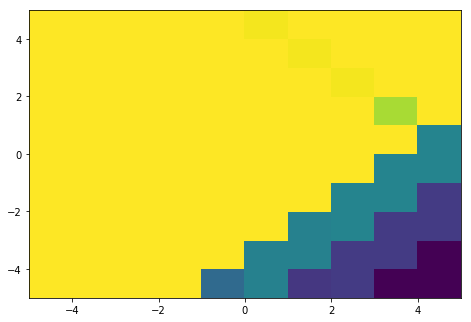

In [8]:
# plot copter value fcn
map_init = prob['env_x0']

def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    return val_copt_list[0][(scop,) + tuple(mapstate)]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), map_init)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals)

print ('success value: {}'.format(copter_value(prob['cop_x0'], map_init)))

exploration ends at t=26.00 with belief (0, 1, 0.15000000000000002, 1, 1, 0.5)
mission ends at t=38.400000000000276
exploration ends at t=26.60 with belief (0.85, 1, 0, 0.15000000000000002, 0.5, 0.85)
mission ends at t=39.9000000000003
exploration ends at t=22.30 with belief (0.85, 1, 0.85, 0.85, 0.15000000000000002, 0.5)
mission ends at t=22.300000000000047
exploration ends at t=26.00 with belief (0, 1, 0.85, 1, 0, 0.5)
mission ends at t=26.0000000000001


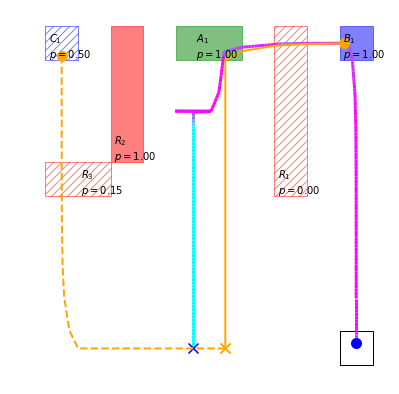

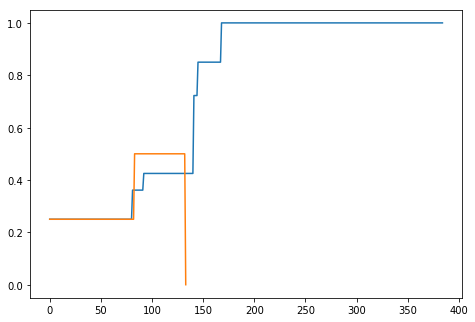

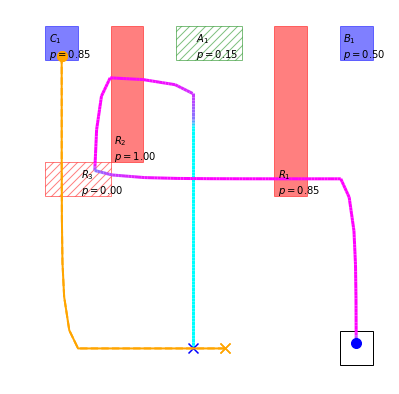

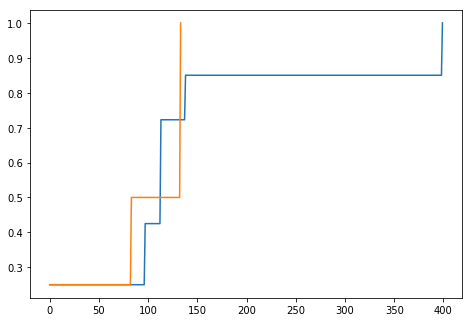

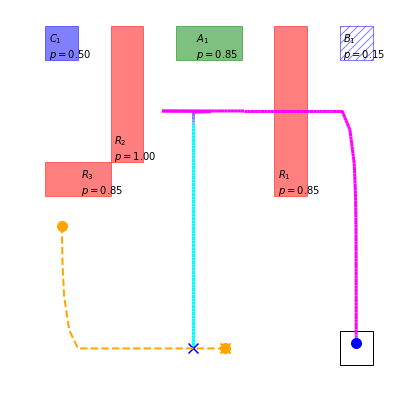

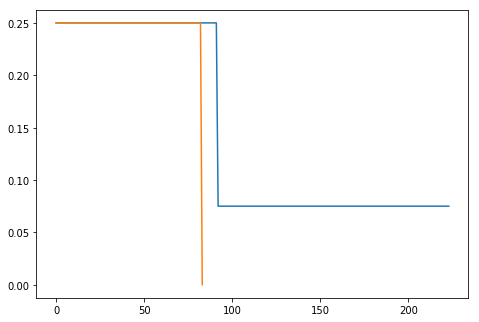

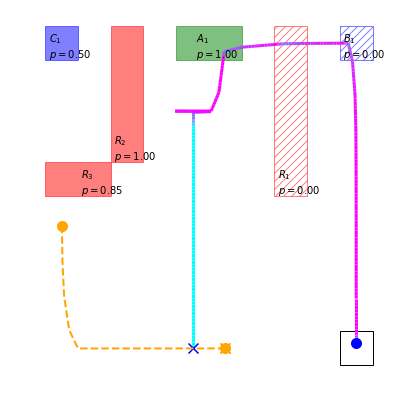

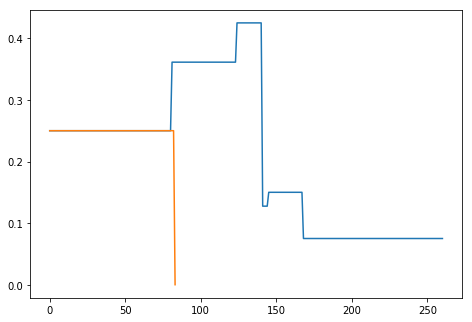

In [9]:
# Simulations
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import matplotlib.patches as patches

realmaps = ([0, 0, 0, 4, 4, 0], [4, 0, 0, 0, 4, 4], [4, 0, 4, 4, 0, 4], [0, 0, 4, 4, 0, 4])   # true map state

for exp_i in range(len(realmaps)):
    realmap = realmaps[exp_i][:]
    
    # Part 1. ROVER ONLY
    rover_policy.reset()
    mapstate = prob['env_x0'][:]

    x_rover_part1 = prob['rov_x0'].reshape((1,2))
    val_part1 = rover_policy.get_value(x_rover_part1[-1,:], mapstate)
    psuccess_part1 = np.array([val_part1])
    tvec_part1 = np.array([0])
    
    while not rover_policy.finished() and val_part1 > 0.:
        x_curr = x_rover_part1[-1, :].flatten()
        mapstate = rf.reveal_map(mapstate, rf.rover_env_sim(x_curr, prob['regs']), realmap)
        belief = rover_env_network.transform_output((0,) + tuple(mapstate))[1:]
        APs = rf.rover_aps_sim(x_curr, belief, rover_env_network.output_names, predicates)
        x_next, val_part1 = rover_policy(x_curr, mapstate, APs)

        x_rover_part1 = np.vstack([x_rover_part1, rf.small_step(x_curr, x_next)])
            
        psuccess_part1 = np.hstack([psuccess_part1, val_part1])
        tvec_part1 = np.hstack([tvec_part1, tvec_part1[-1] + 0.1])   
        

    # Part 2. COPTER AND ROVER
    rover_policy.reset()
    copter_policy.reset()
    mapstate = prob['env_x0'][:]

    x_copter_part2 = prob['cop_x0'].reshape((1,3))
    x_rover_part2 = prob['rov_x0'].reshape((1,2))
  
    val_part2 = rover_policy.get_value(x_rover_part2[-1,:], mapstate)
    psuccess_part2 = np.array([val_part2])
    tvec_part2 = np.array([0])

    # copter simulation
    while not copter_policy.finished():
        x_curr = x_copter_part2[-1, :].flatten()
        mapstate = rf.reveal_map(mapstate, rf.copter_env_sim(x_curr, prob['regs'], prob['cop_sight']), realmap)
        x_next, _ = copter_policy(x_curr, mapstate)
        
        x_copter_part2 = np.vstack([x_copter_part2, rf.small_step(x_curr, x_next)])
        
        val_part2 = rover_policy.get_value(x_rover_part2[-1,:].flatten(), mapstate)
        
        psuccess_part2 = np.hstack([psuccess_part2, val_part2])
        tvec_part2 = np.hstack([tvec_part2, tvec_part2[-1] + 0.1])

    mid_probs = copter_env_network.transform_output((0,) + tuple(mapstate))[1:]
        
    expl_endtime = tvec_part2[-1]
    print ('exploration ends at t={:.2f} with belief {}'.format(expl_endtime, mid_probs))
    
    # rover simulation   
    while not rover_policy.finished() and val_part2 > 0.1:
        x_curr = x_rover_part2[-1, :].flatten()
        mapstate = rf.reveal_map(mapstate, rf.rover_env_sim(x_curr, prob['regs']), realmap)
        belief = rover_env_network.transform_output((0,) + tuple(mapstate))[1:]
        APs = rf.rover_aps_sim(x_curr, belief, rover_env_network.output_names, predicates)
        x_next, val_part2 = rover_policy(x_curr, mapstate, APs)

        x_rover_part2 = np.vstack([x_rover_part2, rf.small_step(x_curr, x_next)])
            
        psuccess_part2 = np.hstack([psuccess_part2, val_part2])
        tvec_part2 = np.hstack([tvec_part2, tvec_part2[-1] + 0.1])
    
    print ('mission ends at t={}'.format(tvec_part2[-1]))
    
    # PLOTTING
    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    ax.axis('off')
    fig.add_axes(ax)
    
    i = 0
    for (name, info) in prob['regs'].items():
        if realmap[i] == 0 and info[1] != 1:
            hatch = '///'
            fill = False
        else:
            hatch = False
            fill = True
        rf.plot_region(ax, info[0], name, mid_probs[i], info[2], hatch=hatch, fill=fill)
        i += 1
        
    points = np.array([x_copter_part2[:,0], x_copter_part2[:,1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('cool'))
    lc.set_array(x_copter_part2[:, 2])
    lc.set_linewidth(3)
    ax.add_collection(lc)
    
    ax.scatter(x_copter_part2[0, 0], x_copter_part2[0, 1], marker='x', color='blue', zorder=2, s=100)
    ax.scatter(x_copter_part2[-1, 0], x_copter_part2[-1, 1], marker='o', color='blue', zorder=2, s=100)

    ax.plot(x_rover_part1[:, 0], x_rover_part1[:, 1], '--', color='orange', linewidth=2)
    ax.scatter(x_rover_part1[0, 0], x_rover_part1[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover_part1[-1, 0], x_rover_part1[-1, 1], marker='o', color='orange', zorder=2, s=100)

    ax.plot(x_rover_part2[:, 0], x_rover_part2[:, 1], color='orange', linewidth=2)
    ax.scatter(x_rover_part2[0, 0], x_rover_part2[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover_part2[-1, 0], x_rover_part2[-1, 1], marker='o', color='orange', zorder=2, s=100)

    ax.add_patch(patches.Rectangle( prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))

    fig.savefig('exp2-{}-trajectory.pdf'.format(exp_i))

    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    ax.plot(psuccess_part2)
    ax.plot(psuccess_part1)

    np.savetxt('exp2-{}-proba-part2.txt'.format(exp_i), 
               np.vstack([psuccess_part2, tvec_part2]).T, delimiter=' ')
    np.savetxt('exp2-{}-proba-part1.txt'.format(exp_i),
               np.vstack([psuccess_part1, expl_endtime+tvec_part1]).T, delimiter=' ')